Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 79.7 MB/s 
     |████████████████████████████████| 120 kB 81.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3862056f8722c3911c880e6fe251ea0850c8a49d937abf8143ac026f65354497
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-PARTY', 'I-DOC_NAME', 'I-PARTY', 'B-AGMT_DATE', 'B-DOC_NAME', 'I-AGMT_DATE', 'O']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

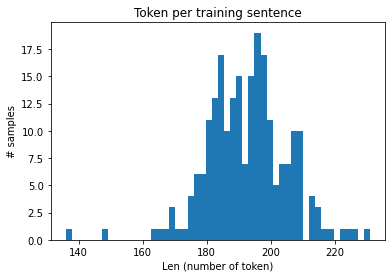

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

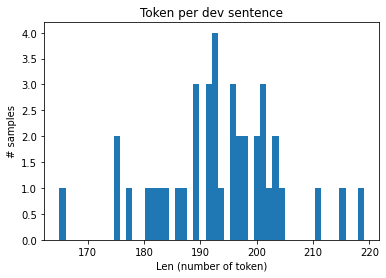

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

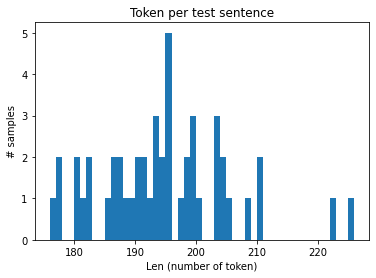

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

3871
forms
0
I-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.33628)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[5777, 4641, 6626, 4901, 1300, 5723, 6502, 1525, 5877, 7066, 1046, 133, 3257, 4840, 1295, 133, 4094, 1514, 604, 2429, 3604, 6367, 3244, 4063, 4072, 2429, 7092, 271, 1148, 4722, 3416, 4836, 2918, 4063, 4072, 7092, 5458, 2918, 5028, 133, 423, 6914, 4957, 3121, 3235, 5564, 3254, 4722, 1472, 2429, 6968, 3845, 984, 3528, 6727, 5869, 2096, 6727, 486, 2419, 3854, 2602, 1054, 558, 1210, 6337, 896, 2163, 3618, 133, 644, 6934, 3200, 2941, 5869, 2096, 3200, 486, 2419, 558, 4207, 2941, 5869, 2096, 4207, 486, 2419, 5869, 2602, 2096, 6337, 486, 2419, 5252, 6021, 2254, 3544, 2150, 4636, 2328, 5608, 4957, 7176, 2059, 3200, 558, 4207, 311, 5635, 3854, 523, 6238, 5872, 3854, 2602, 980, 3470, 558, 2834, 3854, 3591, 1004, 558, 5176, 5872, 311, 6635, 7141, 768, 2954, 3854, 2602, 3553, 558, 915, 6536, 577, 6873, 2145, 2602, 1352, 2590, 1778, 3854, 3809, 6621, 4636, 2602, 6337, 133, 3200, 558, 4207, 311, 1113, 5635, 3854, 5222, 6758, 2602, 4524, 3238, 2024, 6732, 5912, 3522, 1533, 4869, 1615, 558, 3854, 7077

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[5777, 4641, 6626, 4901, 1300, 5723, 6502, 1525, 5877, 7066, 1046, 133, 3257, 4840, 1295, 133, 4094, 1514, 604, 2429, 3604, 6367, 3244, 4063, 4072, 2429, 7092, 271, 1148, 4722, 3416, 4836, 2918, 4063, 4072, 7092, 5458, 2918, 5028, 133, 423, 6914, 4957, 3121, 3235, 5564, 3254, 4722, 1472, 2429, 6968, 3845, 984, 3528, 6727, 5869, 2096, 6727, 486, 2419, 3854, 2602, 1054, 558, 1210, 6337, 896, 2163, 3618, 133, 644, 6934, 3200, 2941, 5869, 2096, 3200, 486, 2419, 558, 4207, 2941, 5869, 2096, 4207, 486, 2419, 5869, 2602, 2096, 6337, 486, 2419, 5252, 6021, 2254, 3544, 2150, 4636, 2328, 5608, 4957, 7176, 2059, 3200, 558, 4207, 311, 5

In [2]:
from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]
      replaceable_indices = [i for i,label in enumerate(base_labels[k]) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != sequence_str[index]]
        new_word = random.choice(available_words)
        augmented_sentence[index] = new_word

      # print("Original text->",sequence_str)
      # print("Augmented text->",augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(base_labels[k])

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [8]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9788564443588257
Training loss epoch: 0.5172611765171352
Training accuracy epoch: 0.8471011326498005
Validating model...
Validation Loss: 0.1807268001139164
Validation Accuracy: 0.9387638001068712
Training epoch: 2
Training loss per 100 training steps: 0.20368629693984985
Training loss epoch: 0.13546527216308996
Training accuracy epoch: 0.9595779235311415
Validating model...
Validation Loss: 0.098056610673666
Validation Accuracy: 0.9688296393837478
Training epoch: 3
Training loss per 100 training steps: 0.08026773482561111
Training loss epoch: 0.06689992527428426
Training accuracy epoch: 0.9804583776533417
Validating model...
Validation Loss: 0.06939258147031069
Validation Accuracy: 0.9774517187588834
Training epoch: 4
Training loss per 100 training steps: 0.03864814341068268
Training loss epoch: 0.04198096829809641
Training accuracy epoch: 0.9890554149223633
Validating model...
Validation Loss: 0.07773903757333755
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06170439645648003
Validation Accuracy: 0.9832699252402406
Validation duration: 0.00792903333333328 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.92      0.92        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.76      0.89      0.82       122

   micro avg       0.83      0.91      0.87       254
   macro avg       0.86      0.91      0.89       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7488036155700684
Training loss epoch: 0.5052119736608706
Training accuracy epoch: 0.8577702200496851
Validating model...
Validation Loss: 0.18791072443127632
Validation Accuracy: 0.93618566980808
Training epoch: 2
Training loss per 100 training steps: 0.231972798705101
Training loss epoch: 0.1393258087337017
Training accuracy epoch: 0.9571155098041308
Validating model...
Validation Loss: 0.09405709244310856
Validation Accuracy: 0.9698306229479219
Training epoch: 3
Training loss per 100 training steps: 0.07668771594762802
Training loss epoch: 0.06138577616136325
Training accuracy epoch: 0.9837699025963854
Validating model...
Validation Loss: 0.06720725353807211
Validation Accuracy: 0.9804151339447305
Training epoch: 4
Training loss per 100 training steps: 0.053281739354133606
Training loss epoch: 0.03878592444877876
Training accuracy epoch: 0.9899458809197431
Validating model...
Validation Loss: 0.07355700619518757
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06525458171963691
Validation Accuracy: 0.9821815557778963
Validation duration: 0.007887049999999837 minutes
F1-score (test): 82.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.90      0.87        50
    DOC_NAME       0.80      0.91      0.85        82
       PARTY       0.74      0.87      0.80       122

   micro avg       0.78      0.89      0.83       254
   macro avg       0.79      0.89      0.84       254
weighted avg       0.78      0.89      0.83       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.077497720718384
Training loss epoch: 0.5083138644695282
Training accuracy epoch: 0.8463610367529949
Validating model...
Validation Loss: 0.18539556488394737
Validation Accuracy: 0.9373363008033287
Training epoch: 2
Training loss per 100 training steps: 0.1966279000043869
Training loss epoch: 0.13905861150277288
Training accuracy epoch: 0.9567913856656747
Validating model...
Validation Loss: 0.09662368521094322
Validation Accuracy: 0.9755149914759199
Training epoch: 3
Training loss per 100 training steps: 0.09160156548023224
Training loss epoch: 0.0585827924507229
Training accuracy epoch: 0.9850406379984443
Validating model...
Validation Loss: 0.10521857254207134
Validation Accuracy: 0.9748427294393178
Training epoch: 4
Training loss per 100 training steps: 0.05700215324759483
Training loss epoch: 0.03930417732580712
Training accuracy epoch: 0.9895198955305698
Validating model...
Validation Loss: 0.08484426885843277
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06945022232830525
Validation Accuracy: 0.9819156746310327
Validation duration: 0.007855849999999501 minutes
F1-score (test): 85.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.96      0.92        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.73      0.86      0.79       122

   micro avg       0.81      0.91      0.86       254
   macro avg       0.84      0.92      0.88       254
weighted avg       0.81      0.91      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0156772136688232
Training loss epoch: 0.5040973542552245
Training accuracy epoch: 0.8485765019599533
Validating model...
Validation Loss: 0.1626090593636036
Validation Accuracy: 0.9482135829112057
Training epoch: 2
Training loss per 100 training steps: 0.13403886556625366
Training loss epoch: 0.14673979580402374
Training accuracy epoch: 0.9554817437716988
Validating model...
Validation Loss: 0.09989540837705135
Validation Accuracy: 0.9720162672004168
Training epoch: 3
Training loss per 100 training steps: 0.07642946392297745
Training loss epoch: 0.0652376264333725
Training accuracy epoch: 0.9829363474723012
Validating model...
Validation Loss: 0.0821446031332016
Validation Accuracy: 0.9767799491496251
Training epoch: 4
Training loss per 100 training steps: 0.09335067868232727
Training loss epoch: 0.04181238852049175
Training accuracy epoch: 0.9893370695356335
Validating model...
Validation Loss: 0.07763556018471718
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0773904949426651
Validation Accuracy: 0.9842373702676666
Validation duration: 0.007973366666666948 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1275415420532227
Training loss epoch: 0.6041510199245653
Training accuracy epoch: 0.8310701845525235
Validating model...
Validation Loss: 0.27463727816939354
Validation Accuracy: 0.915994762206552
Training epoch: 2
Training loss per 100 training steps: 0.25122159719467163
Training loss epoch: 0.19461108312795036
Training accuracy epoch: 0.9383751013572893
Validating model...
Validation Loss: 0.10823477990925312
Validation Accuracy: 0.9673838708894712
Training epoch: 3
Training loss per 100 training steps: 0.0654425323009491
Training loss epoch: 0.07700794797978903
Training accuracy epoch: 0.9782711948902321
Validating model...
Validation Loss: 0.08576679229736328
Validation Accuracy: 0.9754371472182083
Training epoch: 4
Training loss per 100 training steps: 0.05619536712765694
Training loss epoch: 0.04903971511674555
Training accuracy epoch: 0.9872723329845776
Validating model...
Validation Loss: 0.08178190421313047
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09172914624214172
Validation Accuracy: 0.9796715730185224
Validation duration: 0.008002716666665795 minutes
F1-score (test): 83.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.72      0.76        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.77      0.90      0.83       122

   micro avg       0.81      0.87      0.84       254
   macro avg       0.82      0.84      0.83       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1864469051361084
Training loss epoch: 0.5684960696258043
Training accuracy epoch: 0.840716423377827
Validating model...
Validation Loss: 0.19934726506471634
Validation Accuracy: 0.9336328574111376
Training epoch: 2
Training loss per 100 training steps: 0.24808605015277863
Training loss epoch: 0.1544057138656315
Training accuracy epoch: 0.9516220040609333
Validating model...
Validation Loss: 0.0834339577704668
Validation Accuracy: 0.9757706819671397
Training epoch: 3
Training loss per 100 training steps: 0.07253461331129074
Training loss epoch: 0.06476603850330177
Training accuracy epoch: 0.9833038846402915
Validating model...
Validation Loss: 0.07008779887109995
Validation Accuracy: 0.9805703431084672
Training epoch: 4
Training loss per 100 training steps: 0.03954595699906349
Training loss epoch: 0.039063122319547755
Training accuracy epoch: 0.9896513330397777
Validating model...
Validation Loss: 0.07822008524090052
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0670676589012146
Validation Accuracy: 0.9819522269222432
Validation duration: 0.008017800000000836 minutes
F1-score (test): 81.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.76      0.87      0.81        82
       PARTY       0.73      0.87      0.79       122

   micro avg       0.76      0.87      0.81       254
   macro avg       0.78      0.88      0.83       254
weighted avg       0.76      0.87      0.82       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9892703294754028
Training loss epoch: 0.5571237269200777
Training accuracy epoch: 0.8414282743643654
Validating model...
Validation Loss: 0.2424851916730404
Validation Accuracy: 0.9117503823483527
Training epoch: 2
Training loss per 100 training steps: 0.2067054957151413
Training loss epoch: 0.17684923112392426
Training accuracy epoch: 0.9426436647082435
Validating model...
Validation Loss: 0.1066664531826973
Validation Accuracy: 0.9690842426472517
Training epoch: 3
Training loss per 100 training steps: 0.08659283816814423
Training loss epoch: 0.08087329664512684
Training accuracy epoch: 0.9775972295523806
Validating model...
Validation Loss: 0.07677984517067671
Validation Accuracy: 0.9757529368616225
Training epoch: 4
Training loss per 100 training steps: 0.05840633809566498
Training loss epoch: 0.04455444697094591
Training accuracy epoch: 0.9888913932719658
Validating model...
Validation Loss: 0.08538182731717825
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06134554743766785
Validation Accuracy: 0.9833852233149842
Validation duration: 0.008045899999999998 minutes
F1-score (test): 86.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.88      0.90        50
    DOC_NAME       0.91      0.95      0.93        82
       PARTY       0.78      0.85      0.82       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.019073486328125
Training loss epoch: 0.5514939270521465
Training accuracy epoch: 0.8403585737866124
Validating model...
Validation Loss: 0.20083148032426834
Validation Accuracy: 0.9318052730956943
Training epoch: 2
Training loss per 100 training steps: 0.18253597617149353
Training loss epoch: 0.15096467027538701
Training accuracy epoch: 0.9556043400898918
Validating model...
Validation Loss: 0.09600051119923592
Validation Accuracy: 0.9715374521978
Training epoch: 3
Training loss per 100 training steps: 0.09981057792901993
Training loss epoch: 0.07117137959913204
Training accuracy epoch: 0.981132421996226
Validating model...
Validation Loss: 0.077400092035532
Validation Accuracy: 0.9759335773682505
Training epoch: 4
Training loss per 100 training steps: 0.06503678858280182
Training loss epoch: 0.04305849498824069
Training accuracy epoch: 0.988978027030804
Validating model...
Validation Loss: 0.08147295378148556
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06516148708760738
Validation Accuracy: 0.9831859921678309
Validation duration: 0.007964266666668133 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.85      0.88      0.86        82
       PARTY       0.77      0.88      0.82       122

   micro avg       0.81      0.88      0.84       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.81      0.88      0.84       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.3739707469940186
Training loss epoch: 0.6544170944314254
Training accuracy epoch: 0.8251259412288618
Validating model...
Validation Loss: 0.27220749855041504
Validation Accuracy: 0.9069306563865397
Training epoch: 2
Training loss per 100 training steps: 0.2618454098701477
Training loss epoch: 0.19296729172530927
Training accuracy epoch: 0.940412808426019
Validating model...
Validation Loss: 0.12157882750034332
Validation Accuracy: 0.9663813387809772
Training epoch: 3
Training loss per 100 training steps: 0.07893440127372742
Training loss epoch: 0.07636440506106928
Training accuracy epoch: 0.9804062625444981
Validating model...
Validation Loss: 0.08840018510818481
Validation Accuracy: 0.9756511747217983
Training epoch: 4
Training loss per 100 training steps: 0.03136025369167328
Training loss epoch: 0.043504519584147555
Training accuracy epoch: 0.9889921348095884
Validating model...
Validation Loss: 0.07601126749068499
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07542643100023269
Validation Accuracy: 0.9823130021004787
Validation duration: 0.007861883333333708 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.76      0.88      0.82       122

   micro avg       0.83      0.91      0.86       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0310702323913574
Training loss epoch: 0.5131815091559762
Training accuracy epoch: 0.8469703145408513
Validating model...
Validation Loss: 0.17131923511624336
Validation Accuracy: 0.941834227448126
Training epoch: 2
Training loss per 100 training steps: 0.2017379254102707
Training loss epoch: 0.13969343430117556
Training accuracy epoch: 0.9540547669133661
Validating model...
Validation Loss: 0.09788080304861069
Validation Accuracy: 0.9721571725852729
Training epoch: 3
Training loss per 100 training steps: 0.05797050520777702
Training loss epoch: 0.0657503493130207
Training accuracy epoch: 0.9825504179346713
Validating model...
Validation Loss: 0.08023281302303076
Validation Accuracy: 0.977032232421413
Training epoch: 4
Training loss per 100 training steps: 0.059130918234586716
Training loss epoch: 0.04195188382934583
Training accuracy epoch: 0.9890299386726928
Validating model...
Validation Loss: 0.10159619152545929
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05089066326618195
Validation Accuracy: 0.9864619454928805
Validation duration: 0.007862716666666832 minutes
F1-score (test): 88.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.94      0.93        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.84      0.87      0.85       122

   micro avg       0.87      0.90      0.89       254
   macro avg       0.88      0.91      0.90       254
weighted avg       0.87      0.90      0.89       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9241633415222168
Training loss epoch: 0.5298887129340853
Training accuracy epoch: 0.8465105680909808
Validating model...
Validation Loss: 0.18928763270378113
Validation Accuracy: 0.9355660775396867
Training epoch: 2
Training loss per 100 training steps: 0.15136203169822693
Training loss epoch: 0.12455112203246071
Training accuracy epoch: 0.9626720104305904
Validating model...
Validation Loss: 0.09164546709507704
Validation Accuracy: 0.9748318483506591
Training epoch: 3
Training loss per 100 training steps: 0.0604906864464283
Training loss epoch: 0.052609303079190706
Training accuracy epoch: 0.98668532807832
Validating model...
Validation Loss: 0.07344409916549921
Validation Accuracy: 0.9802316315149867
Training epoch: 4
Training loss per 100 training steps: 0.023644939064979553
Training loss epoch: 0.035128653315561156
Training accuracy epoch: 0.9911833622427654
Validating model...
Validation Loss: 0.06706097349524498
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06266524679958821
Validation Accuracy: 0.9841287176022959
Validation duration: 0.008041333333331598 minutes
F1-score (test): 87.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.85      0.90      0.88       254
   macro avg       0.86      0.90      0.88       254
weighted avg       0.85      0.90      0.88       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0232763290405273
Training loss epoch: 0.5145945158742723
Training accuracy epoch: 0.8520334130251432
Validating model...
Validation Loss: 0.1928095780313015
Validation Accuracy: 0.9335470467565763
Training epoch: 2
Training loss per 100 training steps: 0.21767939627170563
Training loss epoch: 0.1440980090271859
Training accuracy epoch: 0.9538536079345619
Validating model...
Validation Loss: 0.12323970720171928
Validation Accuracy: 0.9609230966983096
Training epoch: 3
Training loss per 100 training steps: 0.09821802377700806
Training loss epoch: 0.06965350226632186
Training accuracy epoch: 0.9809013576866752
Validating model...
Validation Loss: 0.0826852135360241
Validation Accuracy: 0.9769438079874807
Training epoch: 4
Training loss per 100 training steps: 0.03849406540393829
Training loss epoch: 0.04070059768855572
Training accuracy epoch: 0.989859537213417
Validating model...
Validation Loss: 0.07190371304750443
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0628178682178259
Validation Accuracy: 0.9842440657749929
Validation duration: 0.00794938333333448 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.91      0.91      0.91        82
       PARTY       0.79      0.86      0.82       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.86      0.91      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9986591339111328
Training loss epoch: 0.4850432305108933
Training accuracy epoch: 0.855843108563362
Validating model...
Validation Loss: 0.17450421303510666
Validation Accuracy: 0.9403535589667802
Training epoch: 2
Training loss per 100 training steps: 0.2294033020734787
Training loss epoch: 0.11394931606593586
Training accuracy epoch: 0.9672373856049842
Validating model...
Validation Loss: 0.11566452868282795
Validation Accuracy: 0.9651020250994913
Training epoch: 3
Training loss per 100 training steps: 0.10839507728815079
Training loss epoch: 0.06062188717935767
Training accuracy epoch: 0.983946788407224
Validating model...
Validation Loss: 0.07826357521116734
Validation Accuracy: 0.9770598088991544
Training epoch: 4
Training loss per 100 training steps: 0.055599480867385864
Training loss epoch: 0.03762423947808288
Training accuracy epoch: 0.9901523927435583
Validating model...
Validation Loss: 0.06110254488885403
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.061801441758871076
Validation Accuracy: 0.9832231425656754
Validation duration: 0.007908216666669432 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.89      0.89      0.89        82
       PARTY       0.79      0.87      0.82       122

   micro avg       0.84      0.88      0.86       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0187458992004395
Training loss epoch: 0.6057499867110026
Training accuracy epoch: 0.8335887674063656
Validating model...
Validation Loss: 0.2526366263628006
Validation Accuracy: 0.9164800247746125
Training epoch: 2
Training loss per 100 training steps: 0.2649800777435303
Training loss epoch: 0.17949425996769042
Training accuracy epoch: 0.9401522665155297
Validating model...
Validation Loss: 0.1190679781138897
Validation Accuracy: 0.9646090055128961
Training epoch: 3
Training loss per 100 training steps: 0.09436541050672531
Training loss epoch: 0.07535249881801151
Training accuracy epoch: 0.978331208845388
Validating model...
Validation Loss: 0.08899119682610035
Validation Accuracy: 0.9755496592808868
Training epoch: 4
Training loss per 100 training steps: 0.04956640675663948
Training loss epoch: 0.04050466573486725
Training accuracy epoch: 0.989525435013136
Validating model...
Validation Loss: 0.08524498529732227
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06915335655212403
Validation Accuracy: 0.983541402865893
Validation duration: 0.00790593333333239 minutes
F1-score (test): 85.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.85      0.90      0.88        82
       PARTY       0.82      0.84      0.83       122

   micro avg       0.84      0.87      0.85       254
   macro avg       0.84      0.87      0.86       254
weighted avg       0.84      0.87      0.85       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.304435968399048
Training loss epoch: 0.6088221818208694
Training accuracy epoch: 0.8290289193934673
Validating model...
Validation Loss: 0.22488228976726532
Validation Accuracy: 0.9302459492476867
Training epoch: 2
Training loss per 100 training steps: 0.22353827953338623
Training loss epoch: 0.17745198699690046
Training accuracy epoch: 0.9418475818883191
Validating model...
Validation Loss: 0.12857620976865292
Validation Accuracy: 0.9556696332322085
Training epoch: 3
Training loss per 100 training steps: 0.11051683872938156
Training loss epoch: 0.08452999893398512
Training accuracy epoch: 0.9750024351178223
Validating model...
Validation Loss: 0.08864787220954895
Validation Accuracy: 0.9735542060041813
Training epoch: 4
Training loss per 100 training steps: 0.026289300993084908
Training loss epoch: 0.043893025833226386
Training accuracy epoch: 0.9894123579344073
Validating model...
Validation Loss: 0.07629983918741345
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06836990490555764
Validation Accuracy: 0.984066925863875
Validation duration: 0.010881133333331643 minutes
F1-score (test): 86.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.84      0.90      0.87       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.108213186264038
Training loss epoch: 0.5368971292461667
Training accuracy epoch: 0.8426177776055349
Validating model...
Validation Loss: 0.17619623988866806
Validation Accuracy: 0.9423729678604287
Training epoch: 2
Training loss per 100 training steps: 0.1677435040473938
Training loss epoch: 0.12685736623548327
Training accuracy epoch: 0.9631201957071599
Validating model...
Validation Loss: 0.08669553324580193
Validation Accuracy: 0.9717626824931455
Training epoch: 3
Training loss per 100 training steps: 0.06709147244691849
Training loss epoch: 0.06021765903348014
Training accuracy epoch: 0.9846674666123618
Validating model...
Validation Loss: 0.08566533587872982
Validation Accuracy: 0.9773173653415039
Training epoch: 4
Training loss per 100 training steps: 0.03008938953280449
Training loss epoch: 0.03925656837721666
Training accuracy epoch: 0.9890791573735788
Validating model...
Validation Loss: 0.07067308947443962
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06745595447719097
Validation Accuracy: 0.9841594637109639
Validation duration: 0.007917433333333671 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.94      0.93        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.79      0.87      0.82       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.87      0.91      0.89       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.080944299697876
Training loss epoch: 0.5170596412249974
Training accuracy epoch: 0.8506169573950867
Validating model...
Validation Loss: 0.17523697763681412
Validation Accuracy: 0.9363487477730281
Training epoch: 2
Training loss per 100 training steps: 0.21861901879310608
Training loss epoch: 0.12533504391709963
Training accuracy epoch: 0.962520014090819
Validating model...
Validation Loss: 0.08919554948806763
Validation Accuracy: 0.9746716239024282
Training epoch: 3
Training loss per 100 training steps: 0.06768684834241867
Training loss epoch: 0.055946445713440575
Training accuracy epoch: 0.9850833697736588
Validating model...
Validation Loss: 0.08743532001972198
Validation Accuracy: 0.9763690909907213
Training epoch: 4
Training loss per 100 training steps: 0.018033817410469055
Training loss epoch: 0.03230637604636805
Training accuracy epoch: 0.9915265148192633
Validating model...
Validation Loss: 0.07676844950765371
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06754280664026738
Validation Accuracy: 0.9824064897611574
Validation duration: 0.007827766666666017 minutes
F1-score (test): 82.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.88      0.83        50
    DOC_NAME       0.81      0.89      0.85        82
       PARTY       0.75      0.89      0.82       122

   micro avg       0.78      0.89      0.83       254
   macro avg       0.78      0.89      0.83       254
weighted avg       0.78      0.89      0.83       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0452492237091064
Training loss epoch: 0.5291570276021957
Training accuracy epoch: 0.848486760189826
Validating model...
Validation Loss: 0.19089867919683456
Validation Accuracy: 0.9393191654917628
Training epoch: 2
Training loss per 100 training steps: 0.2166566699743271
Training loss epoch: 0.13817825239329112
Training accuracy epoch: 0.9560559146293628
Validating model...
Validation Loss: 0.10960173979401588
Validation Accuracy: 0.9694859347739322
Training epoch: 3
Training loss per 100 training steps: 0.06513163447380066
Training loss epoch: 0.06568264171835922
Training accuracy epoch: 0.982618332296464
Validating model...
Validation Loss: 0.09409656934440136
Validation Accuracy: 0.9731124573914598
Training epoch: 4
Training loss per 100 training steps: 0.055514268577098846
Training loss epoch: 0.042002487040701364
Training accuracy epoch: 0.9898628551928075
Validating model...
Validation Loss: 0.07698759995400906
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06118922866880894
Validation Accuracy: 0.9847328465756112
Validation duration: 0.007897766666671184 minutes
F1-score (test): 87.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.94      0.90        50
    DOC_NAME       0.92      0.94      0.93        82
       PARTY       0.80      0.87      0.83       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.86      0.92      0.89       254
weighted avg       0.85      0.91      0.88       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1729912757873535
Training loss epoch: 0.5710849024000622
Training accuracy epoch: 0.8375701799646267
Validating model...
Validation Loss: 0.2201385349035263
Validation Accuracy: 0.9217729908557413
Training epoch: 2
Training loss per 100 training steps: 0.24329017102718353
Training loss epoch: 0.16619438394194558
Training accuracy epoch: 0.9456004063436247
Validating model...
Validation Loss: 0.11188198439776897
Validation Accuracy: 0.9650762493075677
Training epoch: 3
Training loss per 100 training steps: 0.10516156256198883
Training loss epoch: 0.08507674897000903
Training accuracy epoch: 0.9758119750870845
Validating model...
Validation Loss: 0.09063654206693172
Validation Accuracy: 0.9732608369199758
Training epoch: 4
Training loss per 100 training steps: 0.05312788859009743
Training loss epoch: 0.05142933272180103
Training accuracy epoch: 0.9856959420984437
Validating model...
Validation Loss: 0.07638648059219122
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07447884231805801
Validation Accuracy: 0.9817852519932664
Validation duration: 0.007946833333335235 minutes
F1-score (test): 84.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.86      0.93      0.89        82
       PARTY       0.76      0.89      0.82       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.81      0.88      0.84       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8266551494598389
Training loss epoch: 0.49477759855134146
Training accuracy epoch: 0.8621876725421751
Validating model...
Validation Loss: 0.16807549446821213
Validation Accuracy: 0.9462258372865154
Training epoch: 2
Training loss per 100 training steps: 0.17238903045654297
Training loss epoch: 0.1275279206179437
Training accuracy epoch: 0.9622661821902477
Validating model...
Validation Loss: 0.08816749230027199
Validation Accuracy: 0.9750694493650809
Training epoch: 3
Training loss per 100 training steps: 0.040225449949502945
Training loss epoch: 0.06588099009933926
Training accuracy epoch: 0.9816287987424576
Validating model...
Validation Loss: 0.07856838125735521
Validation Accuracy: 0.9777860845482448
Training epoch: 4
Training loss per 100 training steps: 0.03857801854610443
Training loss epoch: 0.03845770541755926
Training accuracy epoch: 0.9902036377810304
Validating model...
Validation Loss: 0.07145040761679411
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06658908724784851
Validation Accuracy: 0.9846149207805809
Validation duration: 0.007980316666665507 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.84      0.90      0.87       254
weighted avg       0.83      0.89      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9151664972305298
Training loss epoch: 0.5510877512750172
Training accuracy epoch: 0.848283819988709
Validating model...
Validation Loss: 0.1853846311569214
Validation Accuracy: 0.9412081436644764
Training epoch: 2
Training loss per 100 training steps: 0.23382143676280975
Training loss epoch: 0.1463832129679975
Training accuracy epoch: 0.9550097985892069
Validating model...
Validation Loss: 0.09361045807600021
Validation Accuracy: 0.9723662297422524
Training epoch: 3
Training loss per 100 training steps: 0.10737679153680801
Training loss epoch: 0.06826227832408178
Training accuracy epoch: 0.9810859230884416
Validating model...
Validation Loss: 0.06944745779037476
Validation Accuracy: 0.9795186615960156
Training epoch: 4
Training loss per 100 training steps: 0.02386353351175785
Training loss epoch: 0.04062520198169209
Training accuracy epoch: 0.9895023075127808
Validating model...
Validation Loss: 0.07650576904416084
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07049537524580955
Validation Accuracy: 0.9824970891671445
Validation duration: 0.007828749999998764 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.87      0.94      0.90        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.81      0.90      0.85       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.007472276687622
Training loss epoch: 0.5275782268671763
Training accuracy epoch: 0.8462872179645193
Validating model...
Validation Loss: 0.19176790863275528
Validation Accuracy: 0.9290538449027615
Training epoch: 2
Training loss per 100 training steps: 0.22241176664829254
Training loss epoch: 0.14422155029716946
Training accuracy epoch: 0.9536469129696163
Validating model...
Validation Loss: 0.0940174525603652
Validation Accuracy: 0.9733501958921014
Training epoch: 3
Training loss per 100 training steps: 0.05380644276738167
Training loss epoch: 0.06442676732937495
Training accuracy epoch: 0.982998913166426
Validating model...
Validation Loss: 0.08194960560649633
Validation Accuracy: 0.9771666092436155
Training epoch: 4
Training loss per 100 training steps: 0.02671751007437706
Training loss epoch: 0.036959560676699595
Training accuracy epoch: 0.9903858210221133
Validating model...
Validation Loss: 0.08150393795222044
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06888223290443421
Validation Accuracy: 0.9809143080857552
Validation duration: 0.010849166666669892 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.88      0.85        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.72      0.87      0.79       122

   micro avg       0.77      0.88      0.82       254
   macro avg       0.79      0.88      0.83       254
weighted avg       0.78      0.88      0.82       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.261749029159546
Training loss epoch: 0.5869371479465848
Training accuracy epoch: 0.8373932107837628
Validating model...
Validation Loss: 0.20551186800003052
Validation Accuracy: 0.9315909996810469
Training epoch: 2
Training loss per 100 training steps: 0.24052485823631287
Training loss epoch: 0.1423206024226688
Training accuracy epoch: 0.9536909545957164
Validating model...
Validation Loss: 0.11037199385464191
Validation Accuracy: 0.9710589192810319
Training epoch: 3
Training loss per 100 training steps: 0.07057895511388779
Training loss epoch: 0.060587815585590545
Training accuracy epoch: 0.9845092491002515
Validating model...
Validation Loss: 0.08133851550519466
Validation Accuracy: 0.9753578861288492
Training epoch: 4
Training loss per 100 training steps: 0.04682420194149017
Training loss epoch: 0.03976558814091342
Training accuracy epoch: 0.9897481843351761
Validating model...
Validation Loss: 0.08328945562243462
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07882730737328529
Validation Accuracy: 0.9821491362666379
Validation duration: 0.008068333333335431 minutes
F1-score (test): 87.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.88      0.89        50
    DOC_NAME       0.92      0.94      0.93        82
       PARTY       0.81      0.84      0.83       122

   micro avg       0.86      0.88      0.87       254
   macro avg       0.88      0.89      0.88       254
weighted avg       0.86      0.88      0.87       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.719666838645935
Training loss epoch: 0.44953216505902155
Training accuracy epoch: 0.8744518448764111
Validating model...
Validation Loss: 0.16307367011904716
Validation Accuracy: 0.9499860054478826
Training epoch: 2
Training loss per 100 training steps: 0.1641928255558014
Training loss epoch: 0.11090743151449022
Training accuracy epoch: 0.9668250551072087
Validating model...
Validation Loss: 0.09442967362701893
Validation Accuracy: 0.9725561241337789
Training epoch: 3
Training loss per 100 training steps: 0.07737832516431808
Training loss epoch: 0.051481995110710464
Training accuracy epoch: 0.9866536058118422
Validating model...
Validation Loss: 0.08502779435366392
Validation Accuracy: 0.9769051282662828
Training epoch: 4
Training loss per 100 training steps: 0.03601331636309624
Training loss epoch: 0.03736677814629816
Training accuracy epoch: 0.9897212852863154
Validating model...
Validation Loss: 0.07387955766171217
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06262947097420693
Validation Accuracy: 0.9841824643511877
Validation duration: 0.007989333333337829 minutes
F1-score (test): 84.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.82      0.85        50
    DOC_NAME       0.84      0.88      0.86        82
       PARTY       0.78      0.89      0.84       122

   micro avg       0.82      0.87      0.84       254
   macro avg       0.83      0.86      0.85       254
weighted avg       0.82      0.87      0.84       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7881660461425781
Training loss epoch: 0.4588476376874106
Training accuracy epoch: 0.8674997358309416
Validating model...
Validation Loss: 0.19108794815838337
Validation Accuracy: 0.9391936515261049
Training epoch: 2
Training loss per 100 training steps: 0.20989592373371124
Training loss epoch: 0.13284201316890262
Training accuracy epoch: 0.9573452792752535
Validating model...
Validation Loss: 0.09119838662445545
Validation Accuracy: 0.9755759859145069
Training epoch: 3
Training loss per 100 training steps: 0.08201105147600174
Training loss epoch: 0.055931495946078075
Training accuracy epoch: 0.9855691412713193
Validating model...
Validation Loss: 0.10230190865695477
Validation Accuracy: 0.9714851452619404
Training epoch: 4
Training loss per 100 training steps: 0.033658724278211594
Training loss epoch: 0.04720968717620486
Training accuracy epoch: 0.9871051331445742
Validating model...
Validation Loss: 0.08040334843099117
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06977196931838989
Validation Accuracy: 0.9834860821927203
Validation duration: 0.007917733333336703 minutes
F1-score (test): 88.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.96      0.93        50
    DOC_NAME       0.94      0.95      0.95        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.85      0.92      0.88       254
   macro avg       0.87      0.93      0.90       254
weighted avg       0.85      0.92      0.88       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.98607337474823
Training loss epoch: 0.472882452465239
Training accuracy epoch: 0.8566561873071363
Validating model...
Validation Loss: 0.15844057127833366
Validation Accuracy: 0.9507508903299623
Training epoch: 2
Training loss per 100 training steps: 0.16854001581668854
Training loss epoch: 0.12021079961033095
Training accuracy epoch: 0.9647800399202932
Validating model...
Validation Loss: 0.09046223014593124
Validation Accuracy: 0.9710195173886798
Training epoch: 3
Training loss per 100 training steps: 0.0589464046061039
Training loss epoch: 0.05860864530716624
Training accuracy epoch: 0.9844771730320729
Validating model...
Validation Loss: 0.0712919570505619
Validation Accuracy: 0.9799738204639032
Training epoch: 4
Training loss per 100 training steps: 0.04914303496479988
Training loss epoch: 0.03505497922499975
Training accuracy epoch: 0.9909176046777924
Validating model...
Validation Loss: 0.06775741651654243
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06158904582262039
Validation Accuracy: 0.9832626390064307
Validation duration: 0.010945583333333767 minutes
F1-score (test): 84.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.81      0.88      0.84       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.81      0.88      0.85       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.911258578300476
Training loss epoch: 0.49277293398266747
Training accuracy epoch: 0.8600882263595669
Validating model...
Validation Loss: 0.19567448645830154
Validation Accuracy: 0.9314777455765965
Training epoch: 2
Training loss per 100 training steps: 0.18853019177913666
Training loss epoch: 0.13064551140580857
Training accuracy epoch: 0.9602228973186548
Validating model...
Validation Loss: 0.09543989598751068
Validation Accuracy: 0.9751771337694461
Training epoch: 3
Training loss per 100 training steps: 0.07924547791481018
Training loss epoch: 0.05567570110516889
Training accuracy epoch: 0.9856867781259505
Validating model...
Validation Loss: 0.07224614545702934
Validation Accuracy: 0.9798836447303882
Training epoch: 4
Training loss per 100 training steps: 0.04114053025841713
Training loss epoch: 0.0315501910323898
Training accuracy epoch: 0.992522284699218
Validating model...
Validation Loss: 0.07476771902292967
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06151838153600693
Validation Accuracy: 0.9834032205223886
Validation duration: 0.007986899999999271 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.78      0.89      0.83        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.81      0.89      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9633985757827759
Training loss epoch: 0.48739285908994223
Training accuracy epoch: 0.8574459704559937
Validating model...
Validation Loss: 0.14946491084992886
Validation Accuracy: 0.9530064702225884
Training epoch: 2
Training loss per 100 training steps: 0.15417791903018951
Training loss epoch: 0.10942319283882777
Training accuracy epoch: 0.9685828493644971
Validating model...
Validation Loss: 0.07527849543839693
Validation Accuracy: 0.9799171244590105
Training epoch: 3
Training loss per 100 training steps: 0.10764170438051224
Training loss epoch: 0.05132130604414713
Training accuracy epoch: 0.9862195468545041
Validating model...
Validation Loss: 0.08177460823208094
Validation Accuracy: 0.9774238905643415
Training epoch: 4
Training loss per 100 training steps: 0.028781414031982422
Training loss epoch: 0.03941516454021136
Training accuracy epoch: 0.9901928626679024
Validating model...
Validation Loss: 0.09426482394337654
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07115421518683433
Validation Accuracy: 0.9820906416505994
Validation duration: 0.007890433333326048 minutes
F1-score (test): 86.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.94      0.93        50
    DOC_NAME       0.88      0.94      0.91        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.83      0.91      0.87       254
   macro avg       0.85      0.92      0.89       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.204324960708618
Training loss epoch: 0.5199813026757467
Training accuracy epoch: 0.8494851513902177
Validating model...
Validation Loss: 0.162174791097641
Validation Accuracy: 0.9541430535888861
Training epoch: 2
Training loss per 100 training steps: 0.15489469468593597
Training loss epoch: 0.12621868082455226
Training accuracy epoch: 0.964012523470686
Validating model...
Validation Loss: 0.09742817748337984
Validation Accuracy: 0.971667682455765
Training epoch: 3
Training loss per 100 training steps: 0.0913022831082344
Training loss epoch: 0.06355625621619679
Training accuracy epoch: 0.9837638960620041
Validating model...
Validation Loss: 0.06330556143075228
Validation Accuracy: 0.9801843813850362
Training epoch: 4
Training loss per 100 training steps: 0.025550326332449913
Training loss epoch: 0.037079344414884134
Training accuracy epoch: 0.9907450378108793
Validating model...
Validation Loss: 0.059685852378606796
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06522567048668862
Validation Accuracy: 0.9832964532600755
Validation duration: 0.008110100000006544 minutes
F1-score (test): 85.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.87      0.89      0.88        82
       PARTY       0.79      0.89      0.84       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.83      0.89      0.85       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.052645444869995
Training loss epoch: 0.5004734318880808
Training accuracy epoch: 0.846595271496527
Validating model...
Validation Loss: 0.16105099767446518
Validation Accuracy: 0.9452745258913087
Training epoch: 2
Training loss per 100 training steps: 0.21079158782958984
Training loss epoch: 0.1261906043759414
Training accuracy epoch: 0.9609848652081658
Validating model...
Validation Loss: 0.10222277417778969
Validation Accuracy: 0.9703113235768616
Training epoch: 3
Training loss per 100 training steps: 0.06288228183984756
Training loss epoch: 0.05810441076755524
Training accuracy epoch: 0.9853415186044837
Validating model...
Validation Loss: 0.06887095794081688
Validation Accuracy: 0.9825641743921234
Training epoch: 4
Training loss per 100 training steps: 0.020166870206594467
Training loss epoch: 0.03308047899710281
Training accuracy epoch: 0.9915857190757923
Validating model...
Validation Loss: 0.07882137596607208
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05835994333028793
Validation Accuracy: 0.9846867396385826
Validation duration: 0.007847049999994245 minutes
F1-score (test): 85.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.78      0.85      0.81       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.83      0.89      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.210801124572754
Training loss epoch: 0.588735269755125
Training accuracy epoch: 0.835229658137969
Validating model...
Validation Loss: 0.21705903112888336
Validation Accuracy: 0.9317496981050528
Training epoch: 2
Training loss per 100 training steps: 0.2195359319448471
Training loss epoch: 0.1517329815775156
Training accuracy epoch: 0.9538975156460522
Validating model...
Validation Loss: 0.11473471112549305
Validation Accuracy: 0.9664581438268938
Training epoch: 3
Training loss per 100 training steps: 0.10507986694574356
Training loss epoch: 0.06797030698508025
Training accuracy epoch: 0.981980685386674
Validating model...
Validation Loss: 0.07757852785289288
Validation Accuracy: 0.9795263258136035
Training epoch: 4
Training loss per 100 training steps: 0.04184155911207199
Training loss epoch: 0.03665508823469281
Training accuracy epoch: 0.9910060790747798
Validating model...
Validation Loss: 0.07175445090979338
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06333330683410168
Validation Accuracy: 0.982914734451086
Validation duration: 0.011014016666664853 minutes
F1-score (test): 86.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.77      0.90      0.83       122

   micro avg       0.82      0.91      0.86       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.91      0.86       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9506452083587646
Training loss epoch: 0.5291993640363216
Training accuracy epoch: 0.8462227839891225
Validating model...
Validation Loss: 0.203485406935215
Validation Accuracy: 0.9303320503511806
Training epoch: 2
Training loss per 100 training steps: 0.1915798783302307
Training loss epoch: 0.13269473761320114
Training accuracy epoch: 0.9596200378694568
Validating model...
Validation Loss: 0.10749017633497715
Validation Accuracy: 0.9723954358310595
Training epoch: 3
Training loss per 100 training steps: 0.0681198239326477
Training loss epoch: 0.059308724291622636
Training accuracy epoch: 0.9846127489870886
Validating model...
Validation Loss: 0.08199541736394167
Validation Accuracy: 0.9798518511861987
Training epoch: 4
Training loss per 100 training steps: 0.03394155576825142
Training loss epoch: 0.034912973456084725
Training accuracy epoch: 0.9917335142386838
Validating model...
Validation Loss: 0.07119489274919033
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05632166042923927
Validation Accuracy: 0.9849184787635125
Validation duration: 0.007964250000001508 minutes
F1-score (test): 89.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.94      0.92        50
    DOC_NAME       0.94      0.95      0.95        82
       PARTY       0.83      0.89      0.86       122

   micro avg       0.88      0.92      0.90       254
   macro avg       0.89      0.93      0.91       254
weighted avg       0.88      0.92      0.90       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.943131923675537
Training loss epoch: 0.472213227301836
Training accuracy epoch: 0.859910527883412
Validating model...
Validation Loss: 0.1678148191422224
Validation Accuracy: 0.9444533717665604
Training epoch: 2
Training loss per 100 training steps: 0.17225401103496552
Training loss epoch: 0.12172927595674991
Training accuracy epoch: 0.9665434826432744
Validating model...
Validation Loss: 0.08698074333369732
Validation Accuracy: 0.9742289004297792
Training epoch: 3
Training loss per 100 training steps: 0.05173756927251816
Training loss epoch: 0.05566572267562151
Training accuracy epoch: 0.9853193796565636
Validating model...
Validation Loss: 0.08279320225119591
Validation Accuracy: 0.9797862894108823
Training epoch: 4
Training loss per 100 training steps: 0.04852096363902092
Training loss epoch: 0.03393044276162982
Training accuracy epoch: 0.9912554650590696
Validating model...
Validation Loss: 0.0790625773370266
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07329357489943504
Validation Accuracy: 0.9827977824002836
Validation duration: 0.007924283333341008 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.84      0.80        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.78      0.89      0.83       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.81      0.89      0.85       254
weighted avg       0.81      0.89      0.85       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0925121307373047
Training loss epoch: 0.5294833227992057
Training accuracy epoch: 0.848105536755258
Validating model...
Validation Loss: 0.20732862874865532
Validation Accuracy: 0.9323103713667306
Training epoch: 2
Training loss per 100 training steps: 0.20884452760219574
Training loss epoch: 0.14557937085628508
Training accuracy epoch: 0.9552558130921215
Validating model...
Validation Loss: 0.10145256295800209
Validation Accuracy: 0.9683188060929594
Training epoch: 3
Training loss per 100 training steps: 0.0867898091673851
Training loss epoch: 0.062398803699761626
Training accuracy epoch: 0.9841350389704138
Validating model...
Validation Loss: 0.07846523262560368
Validation Accuracy: 0.9775618356169509
Training epoch: 4
Training loss per 100 training steps: 0.050685908645391464
Training loss epoch: 0.03659478472545743
Training accuracy epoch: 0.9900162481601535
Validating model...
Validation Loss: 0.0745061095803976
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06421933285892009
Validation Accuracy: 0.9851895613648578
Validation duration: 0.008007366666667319 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.96      0.93        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.75      0.88      0.81       122

   micro avg       0.82      0.91      0.87       254
   macro avg       0.85      0.93      0.88       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7861623764038086
Training loss epoch: 0.4409528262913227
Training accuracy epoch: 0.8664974665979692
Validating model...
Validation Loss: 0.14955008402466774
Validation Accuracy: 0.9512609711593104
Training epoch: 2
Training loss per 100 training steps: 0.1606932133436203
Training loss epoch: 0.10718321874737739
Training accuracy epoch: 0.9672513812697007
Validating model...
Validation Loss: 0.08356950432062149
Validation Accuracy: 0.9757933327364584
Training epoch: 3
Training loss per 100 training steps: 0.05440988764166832
Training loss epoch: 0.04919991381466389
Training accuracy epoch: 0.9876041326510897
Validating model...
Validation Loss: 0.07287054788321257
Validation Accuracy: 0.9829986129045024
Training epoch: 4
Training loss per 100 training steps: 0.02387922629714012
Training loss epoch: 0.030136373545974492
Training accuracy epoch: 0.9923189293758401
Validating model...
Validation Loss: 0.08205976150929928
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05557501390576362
Validation Accuracy: 0.984218800060218
Validation duration: 0.010909983333340279 minutes
F1-score (test): 87.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.91      0.95      0.93        82
       PARTY       0.78      0.89      0.83       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.86      0.91      0.88       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9475727081298828
Training loss epoch: 0.4642697423696518
Training accuracy epoch: 0.8569247330966989
Validating model...
Validation Loss: 0.15670798532664776
Validation Accuracy: 0.9475218893896213
Training epoch: 2
Training loss per 100 training steps: 0.16063909232616425
Training loss epoch: 0.10540831722319126
Training accuracy epoch: 0.968930043623532
Validating model...
Validation Loss: 0.08234893437474966
Validation Accuracy: 0.9787911994393595
Training epoch: 3
Training loss per 100 training steps: 0.04113256558775902
Training loss epoch: 0.04751307712867856
Training accuracy epoch: 0.9880223885299021
Validating model...
Validation Loss: 0.08162181219086051
Validation Accuracy: 0.9772623575444201
Training epoch: 4
Training loss per 100 training steps: 0.019824659451842308
Training loss epoch: 0.028497572103515268
Training accuracy epoch: 0.9931862754872771
Validating model...
Validation Loss: 0.06169474869966507
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05381009206175804
Validation Accuracy: 0.9853014624283922
Validation duration: 0.007849483333332803 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.82      0.88      0.85       122

   micro avg       0.85      0.90      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0720276832580566
Training loss epoch: 0.5036635346710682
Training accuracy epoch: 0.8486078210532275
Validating model...
Validation Loss: 0.17128585651516914
Validation Accuracy: 0.943768494712471
Training epoch: 2
Training loss per 100 training steps: 0.1891099214553833
Training loss epoch: 0.12793667055666447
Training accuracy epoch: 0.9600299807577499
Validating model...
Validation Loss: 0.0904540466144681
Validation Accuracy: 0.9749807844363811
Training epoch: 3
Training loss per 100 training steps: 0.07181289792060852
Training loss epoch: 0.05643696812912822
Training accuracy epoch: 0.9859331917177748
Validating model...
Validation Loss: 0.08101375214755535
Validation Accuracy: 0.9774381520639029
Training epoch: 4
Training loss per 100 training steps: 0.022495480254292488
Training loss epoch: 0.03417411614209413
Training accuracy epoch: 0.9914603698140633
Validating model...
Validation Loss: 0.0745444679632783
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06550259031355381
Validation Accuracy: 0.9837807647373875
Validation duration: 0.007899699999992056 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.87      0.94      0.90        82
       PARTY       0.77      0.87      0.82       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.83      0.90      0.86       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8148033618927002
Training loss epoch: 0.5008262723684311
Training accuracy epoch: 0.8554661960299536
Validating model...
Validation Loss: 0.20621869713068008
Validation Accuracy: 0.9276114909800742
Training epoch: 2
Training loss per 100 training steps: 0.22646261751651764
Training loss epoch: 0.14471763297915458
Training accuracy epoch: 0.9530152725669204
Validating model...
Validation Loss: 0.10138415545225143
Validation Accuracy: 0.9705565075724936
Training epoch: 3
Training loss per 100 training steps: 0.07285704463720322
Training loss epoch: 0.06503819152712823
Training accuracy epoch: 0.9827006064048934
Validating model...
Validation Loss: 0.07612869329750538
Validation Accuracy: 0.9787974103243179
Training epoch: 4
Training loss per 100 training steps: 0.03929297626018524
Training loss epoch: 0.034716348676010964
Training accuracy epoch: 0.9913208780035843
Validating model...
Validation Loss: 0.09663395769894123
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.062305644527077673
Validation Accuracy: 0.9842278479634494
Validation duration: 0.010873800000005455 minutes
F1-score (test): 84.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.82      0.80        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.77      0.89      0.83       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.845147728919983
Training loss epoch: 0.4819872587919235
Training accuracy epoch: 0.8565258199323896
Validating model...
Validation Loss: 0.16545147448778152
Validation Accuracy: 0.9444821463304198
Training epoch: 2
Training loss per 100 training steps: 0.20648890733718872
Training loss epoch: 0.10964512452483177
Training accuracy epoch: 0.9678249552133329
Validating model...
Validation Loss: 0.08801264129579067
Validation Accuracy: 0.9758569265965076
Training epoch: 3
Training loss per 100 training steps: 0.057732079178094864
Training loss epoch: 0.04471268272027373
Training accuracy epoch: 0.9889907181304917
Validating model...
Validation Loss: 0.0783216068521142
Validation Accuracy: 0.9771424796552786
Training epoch: 4
Training loss per 100 training steps: 0.03306102007627487
Training loss epoch: 0.026731591019779444
Training accuracy epoch: 0.9937675520621904
Validating model...
Validation Loss: 0.07289220206439495
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06826392263174057
Validation Accuracy: 0.9841541889001695
Validation duration: 0.007926233333334191 minutes
F1-score (test): 86.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8811010122299194
Training loss epoch: 0.4902435027062893
Training accuracy epoch: 0.855039212078824
Validating model...
Validation Loss: 0.18554041162133217
Validation Accuracy: 0.937579422786888
Training epoch: 2
Training loss per 100 training steps: 0.21166427433490753
Training loss epoch: 0.13378057517111303
Training accuracy epoch: 0.9596259009754504
Validating model...
Validation Loss: 0.09109641425311565
Validation Accuracy: 0.9732287191812103
Training epoch: 3
Training loss per 100 training steps: 0.08561583608388901
Training loss epoch: 0.062194816581904885
Training accuracy epoch: 0.9834519039229764
Validating model...
Validation Loss: 0.07694440800696611
Validation Accuracy: 0.979203075877947
Training epoch: 4
Training loss per 100 training steps: 0.043169666081666946
Training loss epoch: 0.03911077156662941
Training accuracy epoch: 0.990188919563953
Validating model...
Validation Loss: 0.06882917881011963
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05732002537697554
Validation Accuracy: 0.984023080811016
Validation duration: 0.007980300000008355 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.96      0.94        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.78      0.87      0.82       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.90      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1956839561462402
Training loss epoch: 0.4097479486773754
Training accuracy epoch: 0.879061839650591
Validating model...
Validation Loss: 0.1274426244199276
Validation Accuracy: 0.9652633794162402
Training epoch: 2
Training loss per 100 training steps: 0.10137525200843811
Training loss epoch: 0.07315451555467885
Training accuracy epoch: 0.9806026253548998
Validating model...
Validation Loss: 0.06287629436701536
Validation Accuracy: 0.9809146701309659
Training epoch: 3
Training loss per 100 training steps: 0.03951657935976982
Training loss epoch: 0.03651330717999873
Training accuracy epoch: 0.9903099229858875
Validating model...
Validation Loss: 0.06700594816356897
Validation Accuracy: 0.9808245703618316
Training epoch: 4
Training loss per 100 training steps: 0.008349033072590828
Training loss epoch: 0.02258834872266342
Training accuracy epoch: 0.9944184144082162
Validating model...
Validation Loss: 0.0832674135453999
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05665309503674507
Validation Accuracy: 0.9844154478467096
Validation duration: 0.007971683333335023 minutes
F1-score (test): 85.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.77      0.87      0.82       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9670493602752686
Training loss epoch: 0.41585078835487366
Training accuracy epoch: 0.8766743275355346
Validating model...
Validation Loss: 0.13500961288809776
Validation Accuracy: 0.9557398436894053
Training epoch: 2
Training loss per 100 training steps: 0.10573762655258179
Training loss epoch: 0.09369469909318562
Training accuracy epoch: 0.9713097991159454
Validating model...
Validation Loss: 0.07740729674696922
Validation Accuracy: 0.9787443544592538
Training epoch: 3
Training loss per 100 training steps: 0.06373751908540726
Training loss epoch: 0.04153473135726205
Training accuracy epoch: 0.9886624792921662
Validating model...
Validation Loss: 0.06473925337195396
Validation Accuracy: 0.9823780986796795
Training epoch: 4
Training loss per 100 training steps: 0.02717980556190014
Training loss epoch: 0.023075971656061452
Training accuracy epoch: 0.994152259262795
Validating model...
Validation Loss: 0.062015713192522526
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05218649916350841
Validation Accuracy: 0.9871685971315373
Validation duration: 0.007882200000009713 minutes
F1-score (test): 87.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.96      0.96      0.96        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.81      0.85      0.83       122

   micro avg       0.86      0.90      0.88       254
   macro avg       0.88      0.91      0.90       254
weighted avg       0.86      0.90      0.88       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1867895126342773
Training loss epoch: 0.403010331094265
Training accuracy epoch: 0.8811821779042197
Validating model...
Validation Loss: 0.11567007377743721
Validation Accuracy: 0.9692309275241924
Training epoch: 2
Training loss per 100 training steps: 0.12384701520204544
Training loss epoch: 0.07064899808630862
Training accuracy epoch: 0.9814208169255336
Validating model...
Validation Loss: 0.07491547800600529
Validation Accuracy: 0.9793912086621267
Training epoch: 3
Training loss per 100 training steps: 0.0315612331032753
Training loss epoch: 0.033391637294071505
Training accuracy epoch: 0.9921332615895856
Validating model...
Validation Loss: 0.07276897132396698
Validation Accuracy: 0.9798555346926354
Training epoch: 4
Training loss per 100 training steps: 0.026670856401324272
Training loss epoch: 0.023710334007146543
Training accuracy epoch: 0.9942193626541715
Validating model...
Validation Loss: 0.07566628139466047
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06415977105498313
Validation Accuracy: 0.9836953477428911
Validation duration: 0.00788433333333766 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.96      0.93        50
    DOC_NAME       0.83      0.87      0.85        82
       PARTY       0.81      0.90      0.85       122

   micro avg       0.83      0.90      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.90      0.87       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.112277030944824
Training loss epoch: 0.34667187261170357
Training accuracy epoch: 0.8926863802730918
Validating model...
Validation Loss: 0.10982036776840687
Validation Accuracy: 0.9658369631603756
Training epoch: 2
Training loss per 100 training steps: 0.08319833874702454
Training loss epoch: 0.06432619433978508
Training accuracy epoch: 0.9829417495148586
Validating model...
Validation Loss: 0.07657456770539284
Validation Accuracy: 0.9768783926176463
Training epoch: 3
Training loss per 100 training steps: 0.04001232981681824
Training loss epoch: 0.029793835084499985
Training accuracy epoch: 0.9924372219810309
Validating model...
Validation Loss: 0.06875547766685486
Validation Accuracy: 0.9807574841341646
Training epoch: 4
Training loss per 100 training steps: 0.00936239492148161
Training loss epoch: 0.023451491676527877
Training accuracy epoch: 0.9935500103804936
Validating model...
Validation Loss: 0.07967636734247208
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06859996691346168
Validation Accuracy: 0.9841566583213932
Validation duration: 0.01077904999998888 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.90      0.86        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.76      0.88      0.82       122

   micro avg       0.81      0.90      0.86       254
   macro avg       0.83      0.91      0.86       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.308014392852783
Training loss epoch: 0.440881894066416
Training accuracy epoch: 0.8724937276146383
Validating model...
Validation Loss: 0.13791553676128387
Validation Accuracy: 0.9601616146792735
Training epoch: 2
Training loss per 100 training steps: 0.13187332451343536
Training loss epoch: 0.07735918170033858
Training accuracy epoch: 0.9778905947169098
Validating model...
Validation Loss: 0.08449346572160721
Validation Accuracy: 0.9776606930436766
Training epoch: 3
Training loss per 100 training steps: 0.029956435784697533
Training loss epoch: 0.03729274445052805
Training accuracy epoch: 0.9899052214724587
Validating model...
Validation Loss: 0.0861941147595644
Validation Accuracy: 0.9766507598013127
Training epoch: 4
Training loss per 100 training steps: 0.029424045234918594
Training loss epoch: 0.024663746750367612
Training accuracy epoch: 0.9939580829127104
Validating model...
Validation Loss: 0.09845834225416183
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06526699028909207
Validation Accuracy: 0.9815652953723477
Validation duration: 0.00794026666665862 minutes
F1-score (test): 84.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.94      0.90        50
    DOC_NAME       0.81      0.85      0.83        82
       PARTY       0.77      0.90      0.83       122

   micro avg       0.80      0.89      0.85       254
   macro avg       0.81      0.90      0.85       254
weighted avg       0.80      0.89      0.85       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.195324659347534
Training loss epoch: 0.3823497683323663
Training accuracy epoch: 0.8848068909074385
Validating model...
Validation Loss: 0.11643492802977562
Validation Accuracy: 0.9698610054745934
Training epoch: 2
Training loss per 100 training steps: 0.11637923866510391
Training loss epoch: 0.07029627090127304
Training accuracy epoch: 0.9817853825491236
Validating model...
Validation Loss: 0.08713294565677643
Validation Accuracy: 0.9779502277611734
Training epoch: 3
Training loss per 100 training steps: 0.048916351050138474
Training loss epoch: 0.03606122134831445
Training accuracy epoch: 0.9910063044900845
Validating model...
Validation Loss: 0.09042449854314327
Validation Accuracy: 0.9774765300578306
Training epoch: 4
Training loss per 100 training steps: 0.01990940421819687
Training loss epoch: 0.023935732865256482
Training accuracy epoch: 0.9940151598696635
Validating model...
Validation Loss: 0.0926575418561697
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0651700783520937
Validation Accuracy: 0.9850078042429672
Validation duration: 0.00799295000000105 minutes
F1-score (test): 87.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.88      0.85        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.84      0.91      0.88       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.84      0.91      0.88       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8570077419281006
Training loss epoch: 0.3511420650214985
Training accuracy epoch: 0.8939722494730037
Validating model...
Validation Loss: 0.12914739549160004
Validation Accuracy: 0.9619483444797909
Training epoch: 2
Training loss per 100 training steps: 0.15698453783988953
Training loss epoch: 0.0724420655390312
Training accuracy epoch: 0.9805714913159179
Validating model...
Validation Loss: 0.07936587557196617
Validation Accuracy: 0.9775307842166581
Training epoch: 3
Training loss per 100 training steps: 0.04629165306687355
Training loss epoch: 0.030425349411008686
Training accuracy epoch: 0.9918433820179458
Validating model...
Validation Loss: 0.08696258068084717
Validation Accuracy: 0.9769163789515847
Training epoch: 4
Training loss per 100 training steps: 0.026670513674616814
Training loss epoch: 0.022120274892397995
Training accuracy epoch: 0.994651056162941
Validating model...
Validation Loss: 0.08276488166302443
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0679718717932701
Validation Accuracy: 0.9807777465655485
Validation duration: 0.007942783333328407 minutes
F1-score (test): 84.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.74      0.89      0.81       122

   micro avg       0.80      0.90      0.85       254
   macro avg       0.82      0.90      0.85       254
weighted avg       0.80      0.90      0.85       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9788998365402222
Training loss epoch: 0.3888934565515354
Training accuracy epoch: 0.8835782650420326
Validating model...
Validation Loss: 0.12034512683749199
Validation Accuracy: 0.9631576721419713
Training epoch: 2
Training loss per 100 training steps: 0.11131220310926437
Training loss epoch: 0.07702122509864898
Training accuracy epoch: 0.9788056254535477
Validating model...
Validation Loss: 0.09104573912918568
Validation Accuracy: 0.9755107795028475
Training epoch: 3
Training loss per 100 training steps: 0.042555663734674454
Training loss epoch: 0.03617283501180595
Training accuracy epoch: 0.9902912502007402
Validating model...
Validation Loss: 0.07263972703367472
Validation Accuracy: 0.981831170997653
Training epoch: 4
Training loss per 100 training steps: 0.03836250305175781
Training loss epoch: 0.023324868192189728
Training accuracy epoch: 0.9941048178999347
Validating model...
Validation Loss: 0.07761279121041298
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05930521935224533
Validation Accuracy: 0.9842017487596062
Validation duration: 0.008084266666658853 minutes
F1-score (test): 85.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.84      0.85        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.80      0.88      0.84       122

   micro avg       0.83      0.88      0.85       254
   macro avg       0.84      0.87      0.86       254
weighted avg       0.83      0.88      0.85       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.043562650680542
Training loss epoch: 0.3665327162578188
Training accuracy epoch: 0.8841841193143803
Validating model...
Validation Loss: 0.11254862509667873
Validation Accuracy: 0.9643154908410324
Training epoch: 2
Training loss per 100 training steps: 0.10581261664628983
Training loss epoch: 0.07178675492518935
Training accuracy epoch: 0.9808229768782881
Validating model...
Validation Loss: 0.07365742325782776
Validation Accuracy: 0.9782878551558416
Training epoch: 3
Training loss per 100 training steps: 0.06541356444358826
Training loss epoch: 0.03467044587536105
Training accuracy epoch: 0.9908675829069906
Validating model...
Validation Loss: 0.06803104933351278
Validation Accuracy: 0.9817979853597008
Training epoch: 4
Training loss per 100 training steps: 0.013535856269299984
Training loss epoch: 0.022060522905968386
Training accuracy epoch: 0.9945478048724471
Validating model...
Validation Loss: 0.08173631224781275
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06781682819128036
Validation Accuracy: 0.9821942518800576
Validation duration: 0.00789590000000923 minutes
F1-score (test): 87.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.96      0.92        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.84      0.92      0.88       254
   macro avg       0.85      0.93      0.89       254
weighted avg       0.84      0.92      0.88       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1521122455596924
Training loss epoch: 0.4582326016549406
Training accuracy epoch: 0.8679220990066011
Validating model...
Validation Loss: 0.17025117203593254
Validation Accuracy: 0.9501986659540892
Training epoch: 2
Training loss per 100 training steps: 0.13202500343322754
Training loss epoch: 0.0969442536347899
Training accuracy epoch: 0.9725464990778598
Validating model...
Validation Loss: 0.08131952118128538
Validation Accuracy: 0.9786376068932989
Training epoch: 3
Training loss per 100 training steps: 0.03695012256503105
Training loss epoch: 0.04423592201080816
Training accuracy epoch: 0.9884859896133522
Validating model...
Validation Loss: 0.08769877906888723
Validation Accuracy: 0.9779936075014428
Training epoch: 4
Training loss per 100 training steps: 0.02886783331632614
Training loss epoch: 0.027965164293759857
Training accuracy epoch: 0.9925599155330854
Validating model...
Validation Loss: 0.10162712633609772
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06875155121088028
Validation Accuracy: 0.9799061235934257
Validation duration: 0.007875966666658012 minutes
F1-score (test): 83.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.79      0.85      0.82        82
       PARTY       0.79      0.87      0.83       122

   micro avg       0.80      0.86      0.83       254
   macro avg       0.81      0.86      0.84       254
weighted avg       0.80      0.86      0.83       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0860586166381836
Training loss epoch: 0.22504019769921638
Training accuracy epoch: 0.9313836332891757
Validating model...
Validation Loss: 0.08148296922445297
Validation Accuracy: 0.976438950476521
Training epoch: 2
Training loss per 100 training steps: 0.048148397356271744
Training loss epoch: 0.032007684718752115
Training accuracy epoch: 0.9914047116965478
Validating model...
Validation Loss: 0.07728015631437302
Validation Accuracy: 0.9805959493430233
Training epoch: 3
Training loss per 100 training steps: 0.016538498923182487
Training loss epoch: 0.01794500993728115
Training accuracy epoch: 0.9954678863314992
Validating model...
Validation Loss: 0.09737954335287213
Validation Accuracy: 0.9765174223294776
Training epoch: 4
Training loss per 100 training steps: 0.018321193754673004
Training loss epoch: 0.011756626047651497
Training accuracy epoch: 0.9969136852574053
Validating model...
Validation Loss: 0.09799397829920053
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0730677716434002
Validation Accuracy: 0.9815615697524172
Validation duration: 0.007891149999977642 minutes
F1-score (test): 86.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.84      0.87        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.79      0.87      0.82       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.836321234703064
Training loss epoch: 0.22184879456957182
Training accuracy epoch: 0.9315218596536377
Validating model...
Validation Loss: 0.07225684355944395
Validation Accuracy: 0.9780009869645091
Training epoch: 2
Training loss per 100 training steps: 0.04622393101453781
Training loss epoch: 0.03362043852215273
Training accuracy epoch: 0.9908870630588777
Validating model...
Validation Loss: 0.08267864771187305
Validation Accuracy: 0.9788824292147728
Training epoch: 3
Training loss per 100 training steps: 0.01283100713044405
Training loss epoch: 0.016777624825440478
Training accuracy epoch: 0.9956018326758457
Validating model...
Validation Loss: 0.07950393110513687
Validation Accuracy: 0.9795409633053407
Training epoch: 4
Training loss per 100 training steps: 0.017189888283610344
Training loss epoch: 0.011751298847804336
Training accuracy epoch: 0.9968545049315831
Validating model...
Validation Loss: 0.0876007005572319
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06576380804181099
Validation Accuracy: 0.9810350157589671
Validation duration: 0.00811106666666698 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.75      0.87      0.80        82
       PARTY       0.72      0.83      0.77       122

   micro avg       0.76      0.86      0.81       254
   macro avg       0.79      0.88      0.83       254
weighted avg       0.76      0.86      0.81       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7848155498504639
Training loss epoch: 0.20708901990662543
Training accuracy epoch: 0.9393744166777686
Validating model...
Validation Loss: 0.06673527136445045
Validation Accuracy: 0.9802871108778773
Training epoch: 2
Training loss per 100 training steps: 0.05637464299798012
Training loss epoch: 0.034728690181254296
Training accuracy epoch: 0.9910823889169529
Validating model...
Validation Loss: 0.0808060746639967
Validation Accuracy: 0.978871658010173
Training epoch: 3
Training loss per 100 training steps: 0.021583322435617447
Training loss epoch: 0.018911585620228658
Training accuracy epoch: 0.9948367981418427
Validating model...
Validation Loss: 0.07727047521620989
Validation Accuracy: 0.9810237202051306
Training epoch: 4
Training loss per 100 training steps: 0.006038567516952753
Training loss epoch: 0.013280913523774137
Training accuracy epoch: 0.9963740808070639
Validating model...
Validation Loss: 0.08798640593886375
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.059486279264092445
Validation Accuracy: 0.9824346322007844
Validation duration: 0.00794460000000375 minutes
F1-score (test): 84.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.90      0.87        50
    DOC_NAME       0.85      0.91      0.88        82
       PARTY       0.75      0.87      0.81       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.81      0.89      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9296023845672607
Training loss epoch: 0.2515621689850824
Training accuracy epoch: 0.9274449647008052
Validating model...
Validation Loss: 0.07755052391439676
Validation Accuracy: 0.9760265908305481
Training epoch: 2
Training loss per 100 training steps: 0.0776950940489769
Training loss epoch: 0.04278718546163617
Training accuracy epoch: 0.9885189162008513
Validating model...
Validation Loss: 0.0694465166889131
Validation Accuracy: 0.9805021139997618
Training epoch: 3
Training loss per 100 training steps: 0.030176658183336258
Training loss epoch: 0.02354238963310133
Training accuracy epoch: 0.9935784533621737
Validating model...
Validation Loss: 0.07784313429147005
Validation Accuracy: 0.9797567128324911
Training epoch: 4
Training loss per 100 training steps: 0.019167503342032433
Training loss epoch: 0.014370466402748175
Training accuracy epoch: 0.9959616120858306
Validating model...
Validation Loss: 0.09434228949248791
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.061693068221211435
Validation Accuracy: 0.9829200322470404
Validation duration: 0.008002466666706216 minutes
F1-score (test): 86.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1119730472564697
Training loss epoch: 0.23956139803978435
Training accuracy epoch: 0.9283381475042985
Validating model...
Validation Loss: 0.07585947029292583
Validation Accuracy: 0.9783027634987773
Training epoch: 2
Training loss per 100 training steps: 0.04744582995772362
Training loss epoch: 0.03765351543399064
Training accuracy epoch: 0.9900897649473865
Validating model...
Validation Loss: 0.07242326997220516
Validation Accuracy: 0.9798744331228043
Training epoch: 3
Training loss per 100 training steps: 0.031943414360284805
Training loss epoch: 0.01862051734177951
Training accuracy epoch: 0.9954598269695106
Validating model...
Validation Loss: 0.08869383111596107
Validation Accuracy: 0.9819500463889612
Training epoch: 4
Training loss per 100 training steps: 0.02521609701216221
Training loss epoch: 0.01215908027319401
Training accuracy epoch: 0.9969274375920911
Validating model...
Validation Loss: 0.11361779272556305
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06216055899858475
Validation Accuracy: 0.9839038246059963
Validation duration: 0.007951066666707144 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.84      0.89      0.87       254
   macro avg       0.84      0.89      0.87       254
weighted avg       0.84      0.89      0.87       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.035761833190918
Training loss epoch: 0.24435696816235258
Training accuracy epoch: 0.928028418098189
Validating model...
Validation Loss: 0.102132024243474
Validation Accuracy: 0.9718810271317886
Training epoch: 2
Training loss per 100 training steps: 0.057256195694208145
Training loss epoch: 0.03577085620347868
Training accuracy epoch: 0.990741738086427
Validating model...
Validation Loss: 0.07782957516610622
Validation Accuracy: 0.9798700785547017
Training epoch: 3
Training loss per 100 training steps: 0.02246888540685177
Training loss epoch: 0.018662061505509836
Training accuracy epoch: 0.995163027697767
Validating model...
Validation Loss: 0.08298334665596485
Validation Accuracy: 0.9797840750166584
Training epoch: 4
Training loss per 100 training steps: 0.010096807032823563
Training loss epoch: 0.013303948656182018
Training accuracy epoch: 0.9967411498614456
Validating model...
Validation Loss: 0.0888232421129942
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05232967846095562
Validation Accuracy: 0.9867460056434458
Validation duration: 0.007966883333331983 minutes
F1-score (test): 88.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.96      0.93        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.86      0.92      0.89       254
   macro avg       0.87      0.93      0.90       254
weighted avg       0.86      0.92      0.89       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.060302734375
Training loss epoch: 0.2313032462670092
Training accuracy epoch: 0.9316454857886042
Validating model...
Validation Loss: 0.08113246224820614
Validation Accuracy: 0.9784961533981085
Training epoch: 2
Training loss per 100 training steps: 0.039895880967378616
Training loss epoch: 0.039983744308221755
Training accuracy epoch: 0.9886523009352881
Validating model...
Validation Loss: 0.07901990320533514
Validation Accuracy: 0.9795182664341163
Training epoch: 3
Training loss per 100 training steps: 0.023370686918497086
Training loss epoch: 0.019992036744952202
Training accuracy epoch: 0.9947855933792145
Validating model...
Validation Loss: 0.08947454206645489
Validation Accuracy: 0.9773597403809978
Training epoch: 4
Training loss per 100 training steps: 0.01905563287436962
Training loss epoch: 0.013826112879701612
Training accuracy epoch: 0.9963068735746947
Validating model...
Validation Loss: 0.08941045589745045
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06439885050058365
Validation Accuracy: 0.9832619387567622
Validation duration: 0.007989016666639752 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.86      0.96      0.91        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.82      0.91      0.87       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.91      0.86       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7379958629608154
Training loss epoch: 0.22095717136797152
Training accuracy epoch: 0.9362288329620452
Validating model...
Validation Loss: 0.08372612297534943
Validation Accuracy: 0.9761877538133089
Training epoch: 2
Training loss per 100 training steps: 0.055741552263498306
Training loss epoch: 0.0361752251261159
Training accuracy epoch: 0.9903349751761408
Validating model...
Validation Loss: 0.07534734904766083
Validation Accuracy: 0.9782435479097239
Training epoch: 3
Training loss per 100 training steps: 0.016975708305835724
Training loss epoch: 0.0181222534820176
Training accuracy epoch: 0.9952041060293559
Validating model...
Validation Loss: 0.0899972515180707
Validation Accuracy: 0.9810331426541129
Training epoch: 4
Training loss per 100 training steps: 0.02204447239637375
Training loss epoch: 0.01342174931421157
Training accuracy epoch: 0.9962931007263797
Validating model...
Validation Loss: 0.10425771772861481
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0622656524181366
Validation Accuracy: 0.9819822383880741
Validation duration: 0.007987500000005336 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.84      0.89      0.87       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8592698574066162
Training loss epoch: 0.22551983915138663
Training accuracy epoch: 0.9329337428340545
Validating model...
Validation Loss: 0.08099261298775673
Validation Accuracy: 0.9789272431890337
Training epoch: 2
Training loss per 100 training steps: 0.06177609786391258
Training loss epoch: 0.03493292904213855
Training accuracy epoch: 0.9910139411533844
Validating model...
Validation Loss: 0.07388931419700384
Validation Accuracy: 0.9776998070937516
Training epoch: 3
Training loss per 100 training steps: 0.017574390396475792
Training loss epoch: 0.01646601213060581
Training accuracy epoch: 0.9955522493333365
Validating model...
Validation Loss: 0.0915449745953083
Validation Accuracy: 0.977519904066553
Training epoch: 4
Training loss per 100 training steps: 0.011248516850173473
Training loss epoch: 0.010460442430421449
Training accuracy epoch: 0.9973973605946902
Validating model...
Validation Loss: 0.1076990608125925
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06376286558806896
Validation Accuracy: 0.9812675295617108
Validation duration: 0.008071383333359942 minutes
F1-score (test): 82.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.82      0.80        50
    DOC_NAME       0.82      0.88      0.85        82
       PARTY       0.79      0.84      0.81       122

   micro avg       0.79      0.85      0.82       254
   macro avg       0.79      0.85      0.82       254
weighted avg       0.79      0.85      0.82       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8260855674743652
Training loss epoch: 0.21942511142084473
Training accuracy epoch: 0.9331485226328786
Validating model...
Validation Loss: 0.08438229653984308
Validation Accuracy: 0.9763814469336376
Training epoch: 2
Training loss per 100 training steps: 0.04520343989133835
Training loss epoch: 0.03445173306554033
Training accuracy epoch: 0.9913989580752026
Validating model...
Validation Loss: 0.08670736942440271
Validation Accuracy: 0.9797573235208846
Training epoch: 3
Training loss per 100 training steps: 0.009619860909879208
Training loss epoch: 0.01832664561082135
Training accuracy epoch: 0.9952933851607527
Validating model...
Validation Loss: 0.08186049107462168
Validation Accuracy: 0.9837037928031365
Training epoch: 4
Training loss per 100 training steps: 0.011567036621272564
Training loss epoch: 0.012686932193964981
Training accuracy epoch: 0.9967089675081778
Validating model...
Validation Loss: 0.08815300930291414
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06914534643292428
Validation Accuracy: 0.9837402628093175
Validation duration: 0.00801056666665924 minutes
F1-score (test): 87.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.88      0.83        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.84      0.91      0.87       254
weighted avg       0.84      0.91      0.87       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
